# Fine-tuning with the Hugging Face ecosystem (TRL)

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego) and modified by [AMD](https://www.amd.com)_ to run on AMD GPUs.


This notebook demonstrates how to fine-tune a [Vision Language Model (VLM)](https://huggingface.co/blog/vlms) using the Hugging Face ecosystem, specifically with the [Parameter-Efficient Fine-Tuning (PEFT)](https://huggingface.co/docs/peft/index) and [Transformer Reinforcement Learning (TRL)](https://huggingface.co/docs/trl/index) libraries.

**Note**: This notebook is derived from [fine_tuning_vlm_trl](https://huggingface.co/learn/cookbook/en/fine_tuning_vlm_trl).

## Model and dataset overview

You’ll be fine-tuning the [Qwen2-VL-7B](https://qwenlm.github.io/blog/qwen2-vl/) model on the [ChartQA](https://huggingface.co/datasets/HuggingFaceM4/ChartQA) dataset. This dataset includes images of various chart types paired with question-answer pairs, which is ideal for enhancing the model's visual question-answering capabilities.

## Prerequisites

This tutorial was developed and tested using the following setup. 

### Operating system

- **Ubuntu 22.04**: Ensure your system is running Ubuntu version 22.04.

### Hardware

- **AMD Instinct™ GPUs**: This tutorial was tested on an AMD Instinct MI300X GPU. Ensure you are using an AMD Instinct GPU or compatible hardware with ROCm support and that your system meets the [official requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).

### Software

* **ROCm 6.2**: Install and verify ROCm by following the [ROCm install guide](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/install/quick-start.html). After installation, confirm your setup using:

    ``` bash
    rocm-smi
    ```

    This command lists your AMD GPUs with relevant details, similar to the image below.

   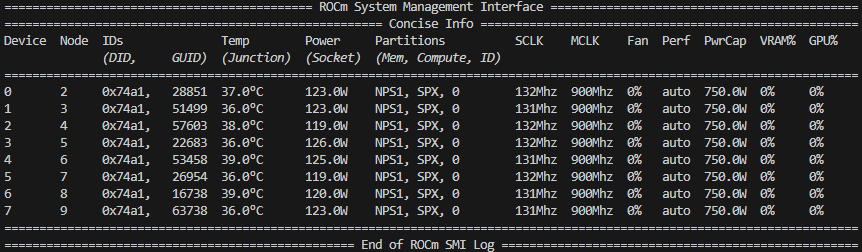


* **Docker**: Ensure Docker is installed and configured correctly. Follow the Docker installation guide for your operating system.

   **Note**: Ensure the Docker permissions are correctly configured. To configure permissions to allow non-root access, run the following commands:

   ``` bash
   sudo usermod -aG docker $USER
   newgrp docker
   ```

   Verify Docker is working correctly:

   ``` bash
   docker run hello-world
   ```

### Hugging Face API access

* Obtain an API token from [Hugging Face](https://huggingface.co) for downloading models.

### Weights & Biases API access

* Obtain an API token from [Weights & Biases (W&B)](https://wandb.ai/).

### Data preparation

* This tutorial uses a sample dataset from Hugging Face, which is prepared during the setup steps.

## Prepare the training environment

Follow these steps to set up the training environment.

### 1. Pull the Docker image

Ensure your system meets the [System Requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).

Pull the Docker image required for this tutorial:

``` bash
docker pull rocm/pytorch:rocm6.2.3_ubuntu22.04_py3.10_pytorch_release_2.3.0
```

### 2. Launch the Docker container

Run this command to launch the Docker container.

``` bash
docker run -it --rm \
  --network=host \
  --device=/dev/kfd \
  --device=/dev/dri \
  --group-add=video \
  --ipc=host \
  --cap-add=SYS_PTRACE \
  --security-opt seccomp=unconfined \
  --shm-size 8G \
  --hostname=ROCm-FT \
  -v $(pwd):/workspace \
  -w /workspace/notebooks \
  rocm/pytorch:rocm6.2.3_ubuntu22.04_py3.10_pytorch_release_2.3.0
```

**Note**: This command mounts the current directory to the `/workspace` directory in the container. Ensure the notebook file is either copied to this directory before running the Docker command or uploaded into the Jupyter Notebook environment after it starts. Save the token or URL provided in the terminal output to access the notebook from your web browser. You can download this notebook from the [AI Developer Hub GitHub repository](https://github.com/ROCm/gpuaidev-docs).


### 3. Install and launch Jupyter

Inside the Docker container, install Jupyter using the following command:

``` bash
pip install jupyter
```

Start the Jupyter server:

```bash
jupyter-lab --ip=0.0.0.0 --port=8888 --no-browser --allow-root
```

**Note**: Ensure port `8888` is not already in use on your system before running the above command. If it is, specify a different port by replacing `--port=8888` with another port number, for example, `--port=8890`.

### 4. Install the dependencies

Verify the Torch library is installed and GPUs are accessible.

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
print("Is a ROCm-GPU detected? ", torch.cuda.is_available())
print("How many ROCm-GPUs are detected? ", torch.cuda.device_count())

Then use `pip` to install the following dependencies for the library.

In [ ]:
# Install necessary libraries for fine-tuning, including parameter-efficient fine-tuning (peft) and transformers
!pip install transformers==4.47.0 trl==0.12.0  peft==0.13.2 qwen-vl-utils==0.0.8 wandb==0.19.1 accelerate==1.1.1 ipywidgets==8.1.5 numpy==1.24.1 numba

Verify the installation:

In [ ]:
# Check for the required libraries and their versions
!pip list | grep -E "transformers|trl|peft|qwen-vl-utils|wandb|accelerate|ipywidgets|numpy|numba"

### 5. Provide your Hugging Face token

Log in to Hugging Face to upload your fine-tuned model. You’ll need to authenticate with your Hugging Face account to save and share your model directly from this notebook.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Verify that your token was accepted correctly:

In [ ]:
from huggingface_hub import HfApi

try:
    api = HfApi()
    user_info = api.whoami()
    print(f"Token validated successfully! Logged in as: {user_info['name']}")
except Exception as e:
    print(f"Token validation failed. Error: {e}")

## Load the dataset

In this section, you’ll load the [HuggingFaceM4/ChartQA](https://huggingface.co/datasets/HuggingFaceM4/ChartQA) dataset. This dataset contains chart images paired with related questions and answers, making it ideal for training on visual question-answering tasks.

Next, generate a system message for the VLM. This creates a system that acts as an expert in analyzing chart images and providing concise answers to questions based on these charts.

**⚠️ Important: ensure the correct kernel is selected**

If the verification process fails, ensure the correct Jupyter kernel is selected for your notebook.
To change the kernel, follow these steps:

1. Go to the **Kernel** menu.
2. Select **Change Kernel**
3. Select `Python 3 (ipykernel)` from the list.

**Failure to select the correct kernel can lead to unexpected issues when running the notebook.**

In [6]:
system_message = """You are a Vision Language Model specializing in interpreting visual data from chart images.
Your task is to analyze the provided chart image and respond to queries with concise answers, usually a single word, number, or short phrase.
The charts include a variety of types (e.g., line charts, bar charts) and contain colors, labels, and text.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

Format the dataset into a chatbot structure for interaction. Each interaction consists of a system message, followed by the image and the user's query, and finally, the answer to the query.

For more usage tips specific to this model, see the [Model Card](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct#more-usage-tips).

In [7]:
def format_data(sample):
    return [
        {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": system_message
                }
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": sample['query'],
                }
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": sample["label"][0]
                }
            ],
        },
    ]

For educational purposes, you’ll only load 10% of each split in the dataset. However, in a real-world use case, you would typically load the entire set of samples.


In [8]:
from datasets import load_dataset

dataset_id = "HuggingFaceM4/ChartQA"
train_dataset, eval_dataset, test_dataset = load_dataset(dataset_id, split=['train[:10%]', 'val[:10%]', 'test[:10%]'])

Next, look at the structure of the dataset. It includes an image, a query, a label (which is the answer), and a fourth feature that you’ll be discarding.


In [ ]:
train_dataset

Format the data using the chatbot structure. This sets up the interactions appropriately for the model.


In [10]:
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in eval_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

In [ ]:
train_dataset[200]

## Load the model and check its performance

After you’ve loaded the dataset, load the model and evaluate its performance using a sample from the dataset. This tutorial uses [Qwen/Qwen2-VL-7B-Instruct](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct), a Vision Language Model (VLM) capable of understanding both visual data and text.

In [3]:
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

model_id = "Qwen/Qwen2-VL-7B-Instruct"

Next, load the model and the tokenizer to prepare for inference.

In [ ]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

To evaluate the model's performance, use a sample from the dataset. First, examine the internal structure of this sample.


In [ ]:
train_dataset[0]

Use the sample without the system message to assess the VLM's raw understanding. Here’s the input to use:

In [ ]:
train_dataset[0][1:2]

Now review the chart corresponding to the sample. Can you answer the query based on the visual information?


In [ ]:
train_dataset[0][1]['content'][0]['image']

Create a method that takes the model, processor, and sample as inputs to generate the model's answer. This allows you to streamline the inference process and easily evaluate the VLM's performance.


In [14]:
from qwen_vl_utils import process_vision_info

def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample[1:2],  # Use the sample without the system message
        tokenize=False,
        add_generation_prompt=True
    )

    # Process the visual input from the sample
    image_inputs, _ = process_vision_info(sample)

    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [ ]:
# Example of how to call the method with sample:
output = generate_text_from_sample(model, processor, train_dataset[0], device="cuda")
output

While the model successfully retrieves the correct visual information, it struggles to answer the question accurately. This indicates that fine-tuning might be the key to enhancing its performance. It's now time to proceed with the fine-tuning process.


### Remove the model and clean the GPU

Before proceeding to train the model in the next section, clear the current variables and clean the GPU to free up resources.

In [ ]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

## Fine-tune the model using TRL

Follow these steps to fine-tune your model.


### 1. Load the model for training

First, load the original model.  

**Note**: Alternatively, the quantized model could be loaded by using [bitsandbytes](https://huggingface.co/docs/bitsandbytes/main/en/index). To learn more about quantization, see [this blog post from Hugging Face](https://huggingface.co/blog/merve/quantization) or [one from Maarten Grootendorst](https://www.maartengrootendorst.com/blog/quantization/).


In [ ]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="cuda",
    torch_dtype=torch.bfloat16
).half()
processor = Qwen2VLProcessor.from_pretrained(model_id)

### 2. Set up LoRA and SFTConfig

Next, configure LoRA for the training setup. LoRA, which reduces memory usage by applying a low-rank approximation, leads to even lower memory requirements and improved training efficiency, making it an excellent choice for optimizing the model's performance without sacrificing quality.


In [ ]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

Use Supervised Fine-tuning (SFT) to refine the model’s performance on the task. To do this, define the training arguments using the [SFTConfig](https://huggingface.co/docs/trl/sft_trainer) class from the [TRL library](https://huggingface.co/docs/trl/index). SFT provides labeled data, helping the model learn to generate more accurate responses based on its input. This approach ensures the model is tailored to your specific use case, leading to better performance in understanding and responding to visual queries.

In [18]:
from trl import SFTConfig

# Configure training arguments
training_args = SFTConfig(
    output_dir="qwen2-7b-instruct-trl-sft-ChartQA",  # Directory to save the model
    num_train_epochs=3,  # Number of training epochs
    per_device_train_batch_size=4,  # Batch size for training
    per_device_eval_batch_size=4,  # Batch size for evaluation
    gradient_accumulation_steps=8,  # Steps to accumulate gradients
    gradient_checkpointing=True,  # Enable gradient checkpointing for memory efficiency
    # Optimizer and scheduler settings
    optim="adamw_torch_fused",  # Optimizer type
    # optim = "adamw_hf",
    learning_rate=2e-4,  # Learning rate for training
    lr_scheduler_type="constant",  # Type of learning rate scheduler
    # Logging and evaluation
    logging_steps=1,  # Steps interval for logging
    eval_steps=10,  # Steps interval for evaluation
    eval_strategy="steps",  # Strategy for evaluation
    save_strategy="steps",  # Strategy for saving the model
    save_steps=20,  # Steps interval for saving
    metric_for_best_model="eval_loss",  # Metric to evaluate the best model
    greater_is_better=False,  # Whether higher metric values are better
    load_best_model_at_end=True,  # Load the best model after training
    # Mixed precision and gradient settings
    bf16=False,  # Use bfloat16 precision
    fp16=True,  # Use float16 precision
    tf32=False,  # Use TensorFloat-32 precision
    max_grad_norm=0.3,  # Maximum norm for gradient clipping
    warmup_ratio=0.03,  # Ratio of total steps for warmup
    # Hub and reporting
    push_to_hub=False,  # Whether to push model to Hugging Face Hub, disable it by default.
    report_to=None,  # Reporting tool for tracking metrics
    # Gradient checkpointing settings
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Options for gradient checkpointing
    # Dataset configuration
    dataset_text_field="",  # Text field in dataset
    dataset_kwargs={"skip_prepare_dataset": True},  # Additional dataset options
    #max_seq_length=1024  # Maximum sequence length for input
)

training_args.remove_unused_columns = False  # Keep unused columns in dataset

### 3. Training the model

You can log your training progress using [Weights & Biases (W&B)](https://wandb.ai/). Connect your notebook to W&B to capture essential information during training.

In [ ]:
import wandb

wandb.init(
    project="qwen2-7b-instruct-trl-sft-ChartQA",  # change this
    name="qwen2-7b-instruct-trl-sft-ChartQA",  # change this
    config=training_args,
)

The model needs a collator function to properly retrieve and batch the data during the training procedure. This function formats the dataset inputs for the model, ensuring they are correctly structured. Define the collator function below.

For more details, see the TRL example [scripts]( https://github.com/huggingface/trl/blob/main/examples/scripts/sft_vlm.py#L87).


In [20]:
# Create a data collator to encode text and image pairs
def collate_fn(examples):
    # Get the texts and images, and apply the chat template
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]  # Prepare texts for processing
    image_inputs = [process_vision_info(example)[0] for example in examples]  # Process the images to extract inputs

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)  # Encode texts and images into tensors

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()  # Clone input IDs for labels
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels

    # Ignore the image token index in the loss computation (model specific)
    if isinstance(processor, Qwen2VLProcessor):  # Check if the processor is Qwen2VLProcessor
        image_tokens = [151652, 151653, 151655]  # Specific image token IDs for Qwen2VLProcessor
    else:
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]  # Convert image token to ID

    # Mask image token IDs in the labels
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    batch["labels"] = labels  # Add labels to the batch

    return batch  # Return the prepared batch

Now, define the [SFTTrainer](https://huggingface.co/docs/trl/sft_trainer), which is a wrapper around the [Transformers Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) class and inherits its attributes and methods. This class simplifies the fine-tuning process by properly initializing the [PeftModel](https://huggingface.co/docs/peft/v0.6.0/package_reference/peft_model) when a [PeftConfig](https://huggingface.co/docs/peft/v0.6.0/en/package_reference/config#peft.PeftConfig) object is provided. By using `SFTTrainer`, you can efficiently manage the training workflow and ensure a smooth fine-tuning experience for the Vision Language Model.

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    tokenizer=processor.tokenizer,
)

It's now time to train the model!

In [ ]:
trainer.train()

Then save the results.

In [ ]:
trainer.save_model(training_args.output_dir)

## Testing the fine-tuned model

Now that you've successfully fine-tuned your Vision Language Model (VLM), it's time to evaluate its performance. This section tests the model using examples from the ChartQA dataset to see how well it answers questions based on chart images. It provides a good way to explore the results.

Clean up the GPU memory to ensure optimal performance:

In [ ]:
clear_memory()

Then reload the base model using the same pipeline as before.

In [ ]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

Attach the trained adapter to the pretrained model. This adapter contains the fine-tuning adjustments you made during training, allowing the base model to leverage the new knowledge without altering its core parameters. Integrating the adapter enhances the model's capabilities while maintaining its original structure.

In [ ]:
import os
os.getcwd()

In [ ]:
adapter_path = "./qwen2-7b-instruct-trl-sft-ChartQA"
model.load_adapter(adapter_path)

Use the previous sample from the dataset that the model initially struggled to answer correctly.

In [ ]:
train_dataset[0][:2]

In [ ]:
train_dataset[0][1]['content'][0]['image']

In [ ]:
output = generate_text_from_sample(model, processor, train_dataset[0])
output

This sample is drawn from the training set, so the model has encountered it during training. This could be seen as a form of cheating. To gain a more comprehensive understanding of the model's performance, evaluate it using an unseen sample.


In [ ]:
test_dataset[10][:2]

In [ ]:
test_dataset[10][1]['content'][0]['image']

In [ ]:
output = generate_text_from_sample(model, processor, test_dataset[10])
output

The model has successfully learned to respond to the queries as specified in the dataset. You've achieved your goal!

## Compare a fine-tuned model versus a base model with prompting

You have explored how fine-tuning the VLM can be a valuable option for adapting it to your specific needs. Another approach to consider is directly using prompting or implementing a RAG system, which is covered in another [recipe](https://huggingface.co/learn/cookbook/multimodal_rag_using_document_retrieval_and_vlms).

Fine-tuning a VLM requires significant amounts of data and computational resources, which can incur costs. In contrast, you can experiment with prompting to see if it can achieve similar results without the overhead of fine-tuning.

Clean up the GPU memory again to ensure optimal performance.

In [ ]:
clear_memory()

First, load the baseline model following the same pipeline as before.


In [ ]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_id,
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

processor = Qwen2VLProcessor.from_pretrained(model_id)

This case uses the previous sample again, but this time it includes the system message as follows. This enhancement helps contextualize the input for the model, potentially improving its response accuracy.

In [ ]:
train_dataset[0][:2]

Now see how it performs:

In [ ]:
text = processor.apply_chat_template(
    train_dataset[0][:2], tokenize=False, add_generation_prompt=True
)

image_inputs, _ = process_vision_info(train_dataset[0])

inputs = processor(
    text=[text],
    images=image_inputs,
    return_tensors="pt",
)

inputs = inputs.to("cuda")

generated_ids = model.generate(**inputs, max_new_tokens=1024)
generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]

output_text = processor.batch_decode(
    generated_ids_trimmed,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)

output_text[0]

As demonstrated, the model generates the correct answer using the pretrained model along with the additional system message, without any training. This approach can serve as a viable alternative to fine-tuning, depending on the specific use case.